# Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path

import torch.nn.functional as F
from torchvision import models
from itertools import chain
from math import ceil

from sklearn.model_selection import train_test_split
from copy import deepcopy

from torchmetrics import JaccardIndex  # This is the same as MeanIoU

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import logging
import functools

from bn_helper import BatchNorm2d, BatchNorm2d_class, relu_inplace



In [2]:
# Method 1: Basic cleanup
import torch
import gc

def cleanup():
    # Clear GPU cache
    torch.cuda.empty_cache()
    # Garbage collect
    gc.collect()

cleanup()

# Device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Hyperparameters

In [4]:
batch_size = 4
num_classes = 30  # Change as per your dataset
num_epochs = 50
learning_rate = 0.0001

# Color ID for different objects

In [5]:
id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

In [6]:
def preprocess_masks(image_dir, save_dir):
    """
    Preprocess all masks and save them as numpy arrays
    """
    # Create save directory if it doesn't exist
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    print("Preprocessing masks...")
    for img_file in tqdm(image_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        
        # Get mask portion (right half of image)
        mask_img = img.crop((256, 0, 512, 256)).resize((256, 256))
        mask_np = np.array(mask_img)
        
        # Create mask using vectorized operations
        h, w = mask_np.shape[:2]
        mask = np.zeros((h, w), dtype=np.int64)
        
        # Vectorized nearest neighbor search
        mask_flat = mask_np.reshape(-1, 3)
        colors = np.array(list(id_map.values()))
        distances = np.linalg.norm(mask_flat[:, np.newaxis] - colors, axis=2)
        nearest_class = np.argmin(distances, axis=1)
        mask = nearest_class.reshape(h, w)
        
        # Save preprocessed mask
        save_path = save_dir / f"{os.path.splitext(img_file)[0]}_mask.npy"
        np.save(save_path, mask)

In [7]:
# Directories
image_dir = "../cityscapes_data/cityscapes_data/train"
mask_dir = "../cityscapes_data/cityscapes_data/mask"

# Preprocess masks (run once)
#preprocess_masks(image_dir, mask_dir)

# Dataloader

In [8]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_file = self.image_files[idx]
        img_path = self.image_dir / img_file
        img = Image.open(img_path)
        
        # Get input image (left half)
        img = img.crop((0, 0, 256, 256)).resize((256, 256))
        
        # Transform image
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.FloatTensor(np.array(img).transpose(2, 0, 1)) / 255.0
        
        # Load preprocessed mask
        mask_path = self.mask_dir / f"{os.path.splitext(img_file)[0]}_mask.npy"
        mask = np.load(mask_path)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
        
        return img, mask

# Create transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
               std=[0.229, 0.224, 0.225])
])


In [9]:
def create_data_loaders(image_dir, mask_dir, batch_size, val_split=0.2):
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    # Split into train and validation
    train_files, val_files = train_test_split(image_files, test_size=val_split, random_state=42)
    
    # Create custom datasets
    class CityscapeDatasetWithFiles(CityscapeDataset):
        def __init__(self, image_dir, mask_dir, file_list, transform=None):
            super().__init__(image_dir, mask_dir, transform)
            self.image_files = file_list
    
    # Create train and validation datasets
    train_dataset = CityscapeDatasetWithFiles(image_dir, mask_dir, train_files)
    val_dataset = CityscapeDatasetWithFiles(image_dir, mask_dir, val_files)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [10]:
# Create training and validation loaders
train_loader, val_loader = create_data_loaders(image_dir, mask_dir, batch_size)
len(train_loader)
len(val_loader)

149

# HRnet architecture

In [11]:
BatchNorm2d = nn.BatchNorm2d

BN_MOMENTUM = 0.01
logger = logging.getLogger(__name__)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=False)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=False)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        #extra = config.MODEL.EXTRA
        extra = config['MODEL']['EXTRA']
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int64(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=False),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=config['NUM_CLASSES'],
                kernel_size=extra['FINAL_CONV_KERNEL'],
                stride=1,
                padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #print(x.shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #x0_h, x0_w = x0_h* 4, x0_w * 2 
        #print(x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if pretrained:
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights(cfg['PRETRAINED'])

    return model

In [12]:
# dict for model configuration
config = {}

config['NUM_CLASSES'] = 30
config['PRETRAINED'] = None

config['MODEL'] = {'EXTRA': {'FINAL_CONV_KERNEL': 1,
      'STAGE1': {'BLOCK': 'BOTTLENECK', 
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [4],
                 'NUM_CHANNELS': [64],
                 'NUM_MODULES': 1,
                 'NUM_RANCHES': 1
                },
      'STAGE2': {'BLOCK': 'BASIC',
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [4, 4],
                 'NUM_BRANCHES': 2,
                 'NUM_CHANNELS': [18, 36],
                 'NUM_MODULES': 1
                },
      'STAGE3':{'BLOCK': 'BASIC',
                'FUSE_METHOD': 'SUM',
                'NUM_BLOCKS': [4, 4, 4],
                'NUM_BRANCHES': 3,
                'NUM_CHANNELS': [18, 36, 72],
                'NUM_MODULES': 4
               },
       'STAGE4': {'BLOCK': 'BASIC',
                 'FUSE_METHOD': 'SUM',
                 'NUM_BLOCKS': [4, 4, 4, 4],
                 'NUM_BRANCHES': 4,
                 'NUM_CHANNELS': [18, 36, 72, 144],
                 'NUM_MODULES': 3
                 }}}

# Training main code

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True, min_epochs=10):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.min_epochs = min_epochs
        self.epoch_counter = 0
    
    def __call__(self, val_loss, model):
        self.epoch_counter += 1
        
        # Don't start early stopping until minimum epochs are reached
        if self.epoch_counter < self.min_epochs:
            if self.best_loss is None or val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_model = deepcopy(model.state_dict())
            return
        
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
            self.counter = 0

  0%|          | 0/595 [00:00<?, ?it/s]C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:437: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:438: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:439: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')



Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 5 12 14 15 16 17]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


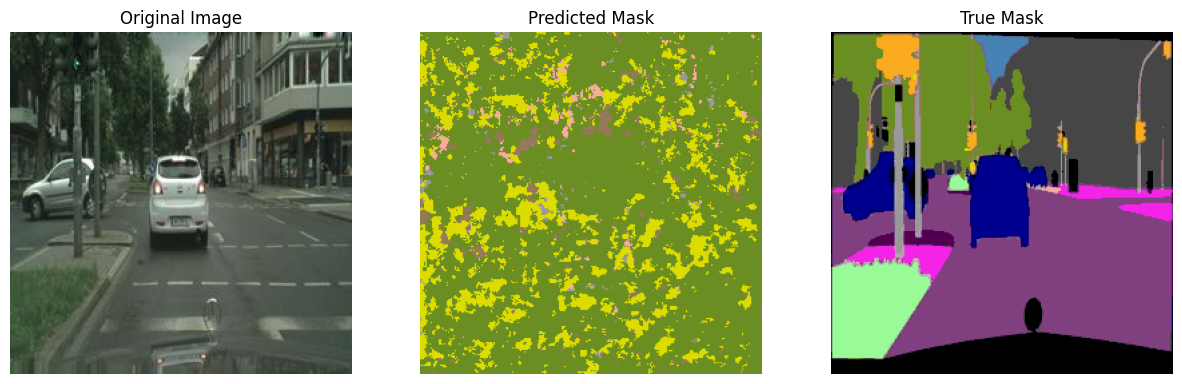

Validation: 100%|██████████| 149/149 [00:40<00:00,  3.71it/s]



Epoch [1/50]
Training Loss: 1.5288, Training mIoU: 0.0976
Validation Loss: 3.2856, Validation mIoU: 0.0264


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  3  4  7 17 19 22]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


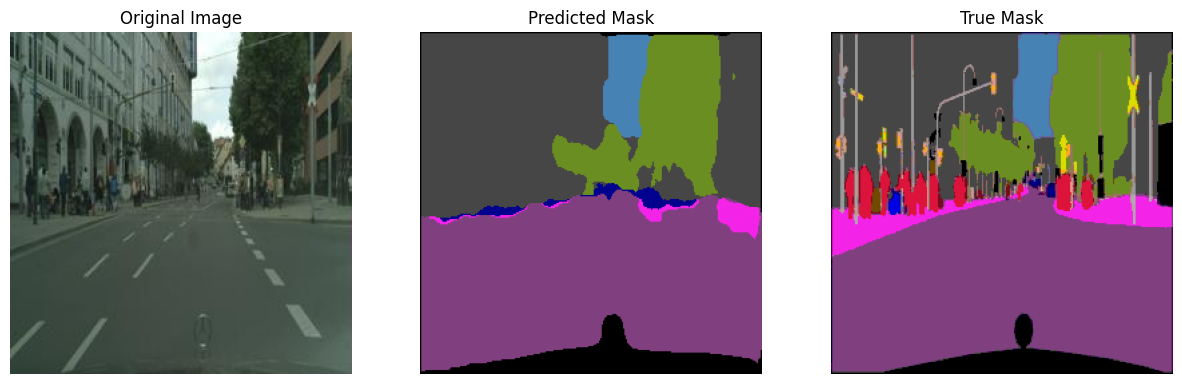

Validation: 100%|██████████| 149/149 [00:31<00:00,  4.77it/s]



Epoch [2/50]
Training Loss: 0.9386, Training mIoU: 0.1626
Validation Loss: 1.3422, Validation mIoU: 0.1159


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7 17 18 19 22 23]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


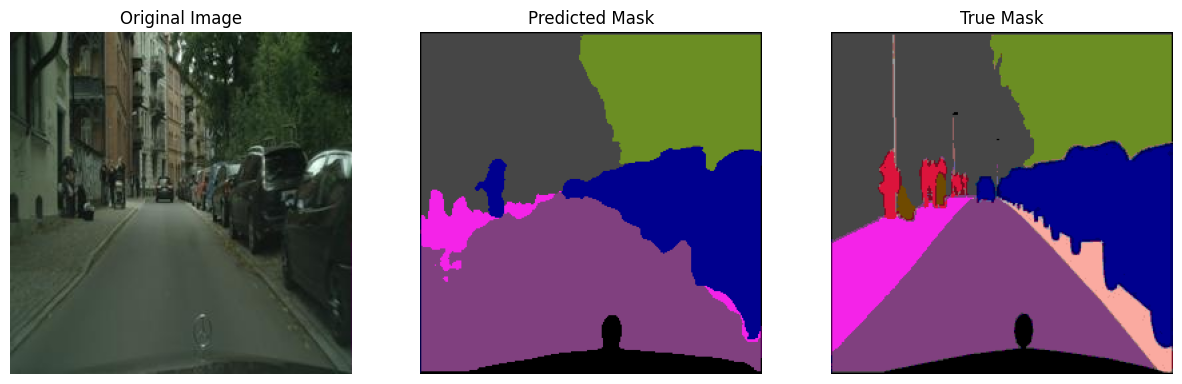

Validation: 100%|██████████| 149/149 [00:31<00:00,  4.76it/s]



Epoch [3/50]
Training Loss: 0.8041, Training mIoU: 0.1934
Validation Loss: 0.7559, Validation mIoU: 0.2098


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


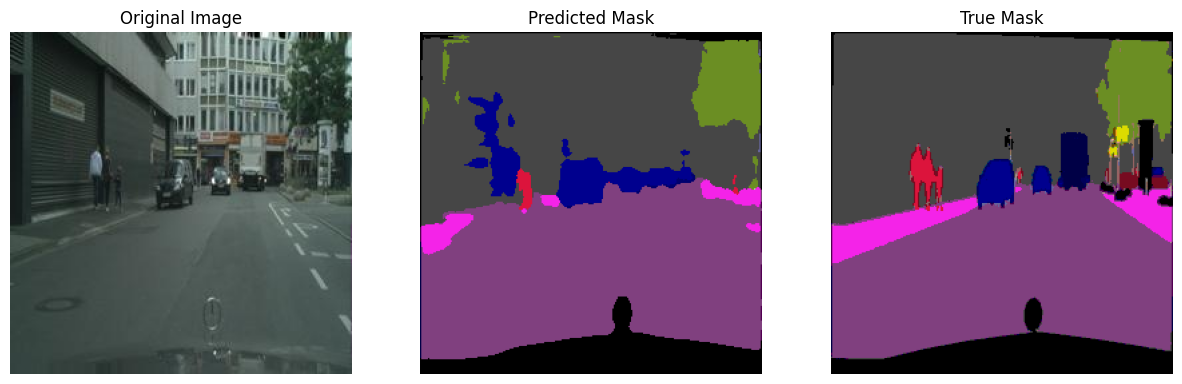

Validation: 100%|██████████| 149/149 [00:34<00:00,  4.28it/s]



Epoch [4/50]
Training Loss: 0.7308, Training mIoU: 0.2174
Validation Loss: 0.7335, Validation mIoU: 0.2193


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


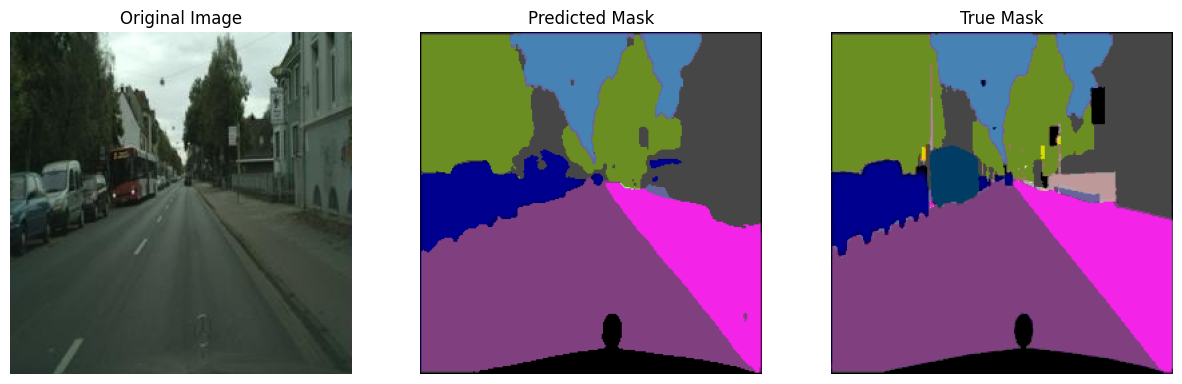

Validation: 100%|██████████| 149/149 [00:35<00:00,  4.16it/s]



Epoch [5/50]
Training Loss: 0.6758, Training mIoU: 0.2309
Validation Loss: 0.7421, Validation mIoU: 0.2220


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 13 16 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


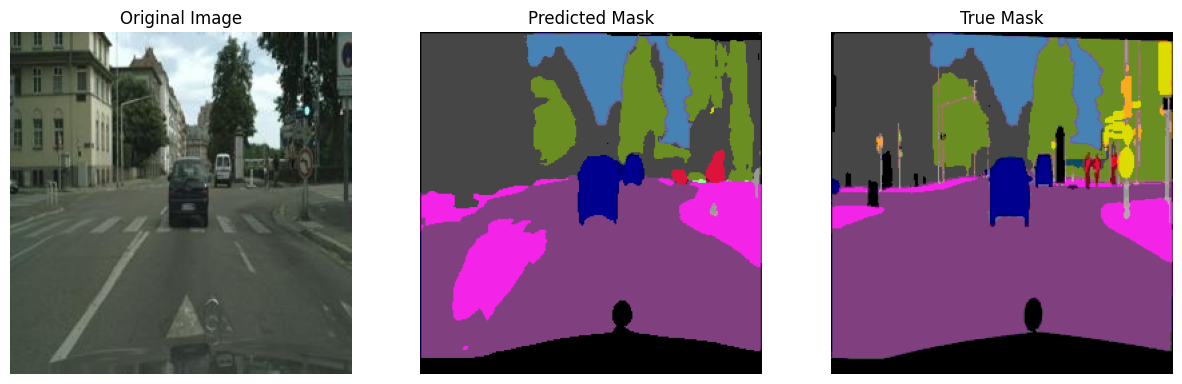

Validation: 100%|██████████| 149/149 [00:39<00:00,  3.80it/s]



Epoch [6/50]
Training Loss: 0.6334, Training mIoU: 0.2451
Validation Loss: 0.6488, Validation mIoU: 0.2427


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 12 13 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


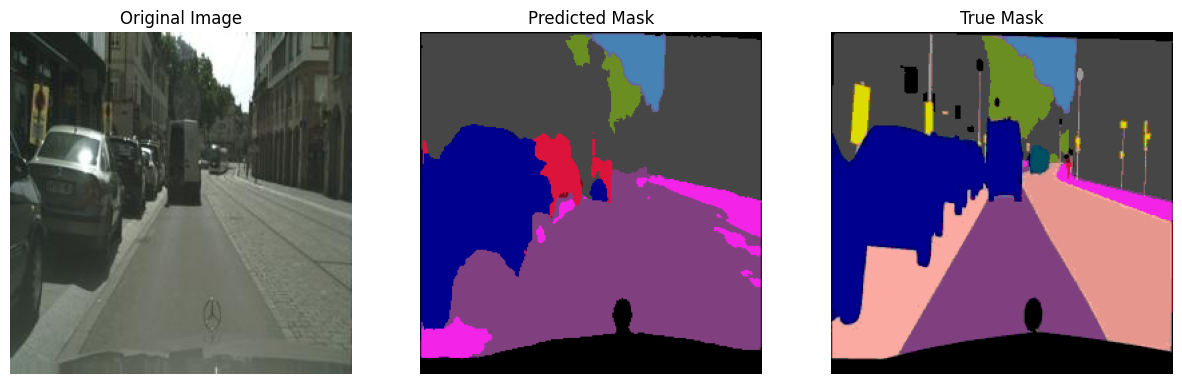

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.51it/s]



Epoch [7/50]
Training Loss: 0.6045, Training mIoU: 0.2566
Validation Loss: 0.6648, Validation mIoU: 0.2477


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 16 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


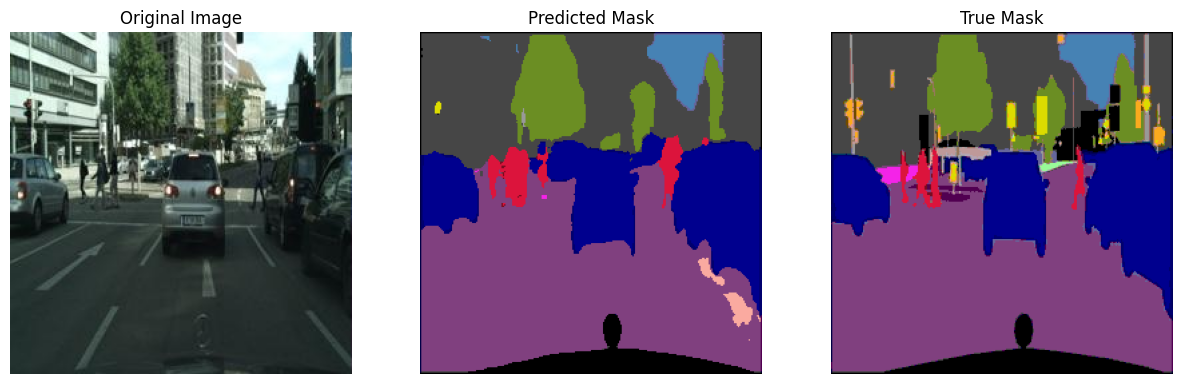

Validation: 100%|██████████| 149/149 [00:40<00:00,  3.72it/s]



Epoch [8/50]
Training Loss: 0.5757, Training mIoU: 0.2669
Validation Loss: 0.6600, Validation mIoU: 0.2460


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 15 16 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


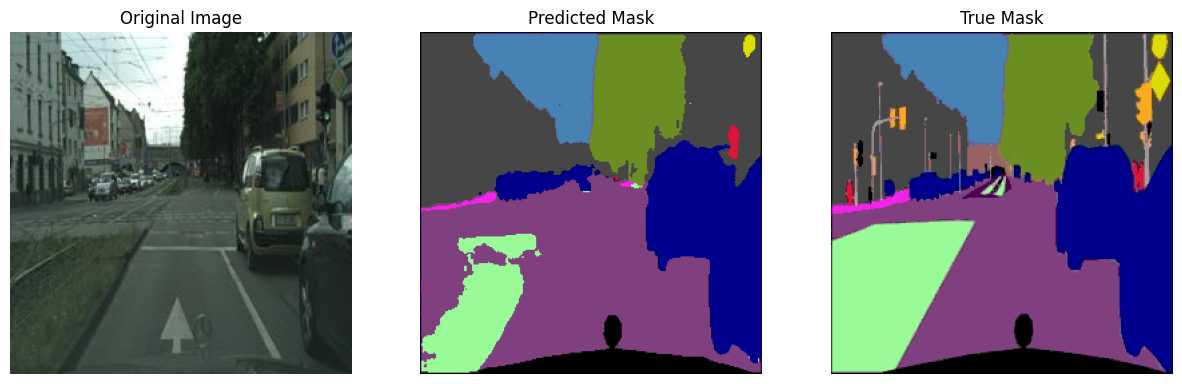

Validation: 100%|██████████| 149/149 [00:41<00:00,  3.56it/s]



Epoch [9/50]
Training Loss: 0.5583, Training mIoU: 0.2738
Validation Loss: 0.5906, Validation mIoU: 0.2654


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 15 16 17 18 19 20 22 23 26]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


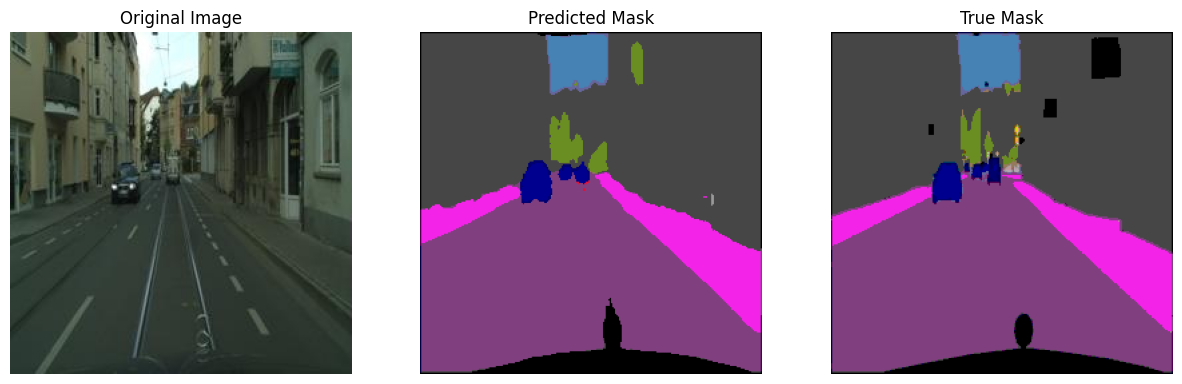

Validation: 100%|██████████| 149/149 [00:30<00:00,  4.93it/s]



Epoch [10/50]
Training Loss: 0.5398, Training mIoU: 0.2814
Validation Loss: 0.6253, Validation mIoU: 0.2674
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  6  7  8  9 10 11 12 13 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


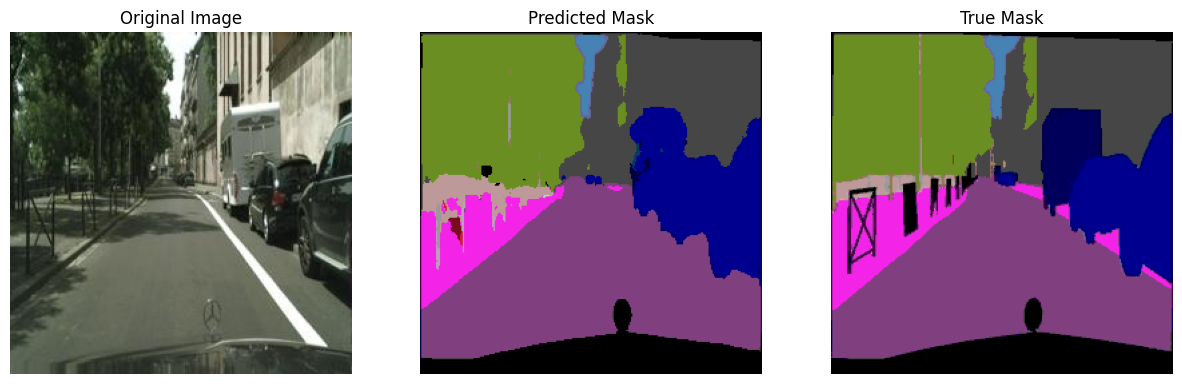

Validation: 100%|██████████| 149/149 [00:39<00:00,  3.76it/s]



Epoch [11/50]
Training Loss: 0.5252, Training mIoU: 0.2876
Validation Loss: 0.5639, Validation mIoU: 0.2782


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


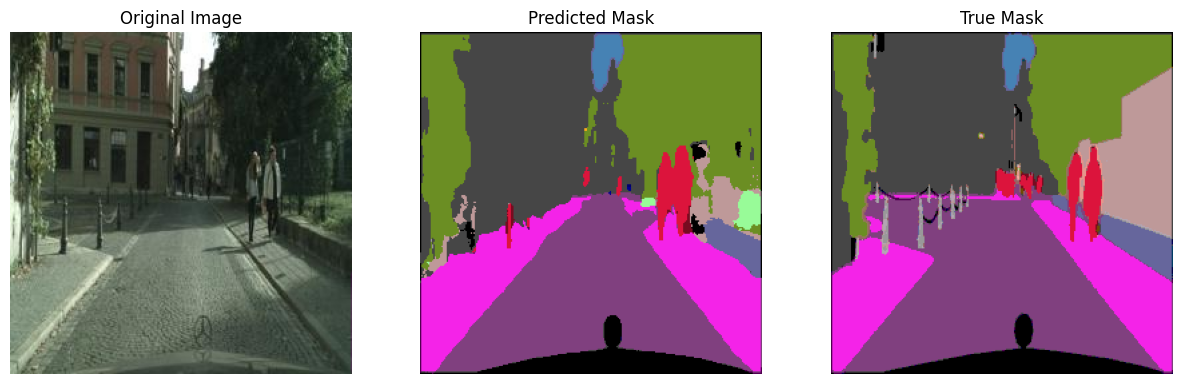

Validation: 100%|██████████| 149/149 [00:36<00:00,  4.08it/s]



Epoch [12/50]
Training Loss: 0.5088, Training mIoU: 0.2937
Validation Loss: 0.5684, Validation mIoU: 0.2804
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


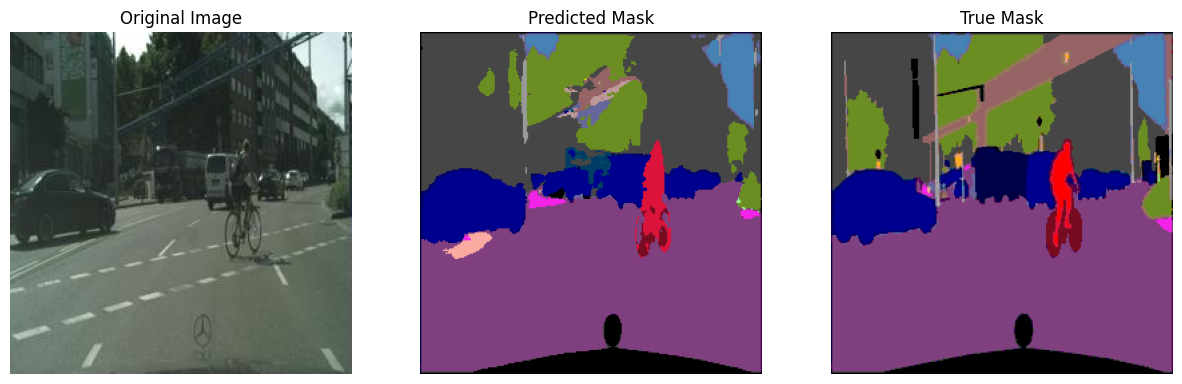

Validation: 100%|██████████| 149/149 [00:30<00:00,  4.83it/s]



Epoch [13/50]
Training Loss: 0.4950, Training mIoU: 0.2985
Validation Loss: 0.6855, Validation mIoU: 0.2484
EarlyStopping counter: 2 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


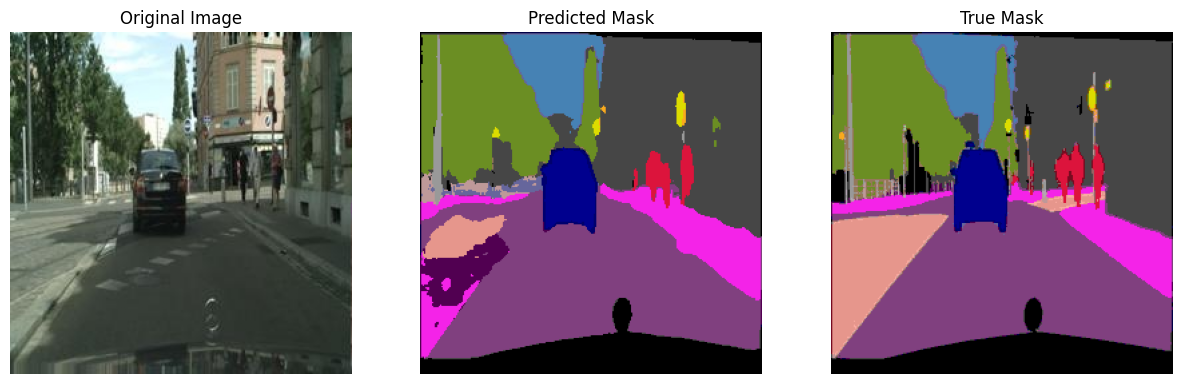

Validation: 100%|██████████| 149/149 [00:42<00:00,  3.54it/s]



Epoch [14/50]
Training Loss: 0.4801, Training mIoU: 0.3042
Validation Loss: 0.6140, Validation mIoU: 0.2717
EarlyStopping counter: 3 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


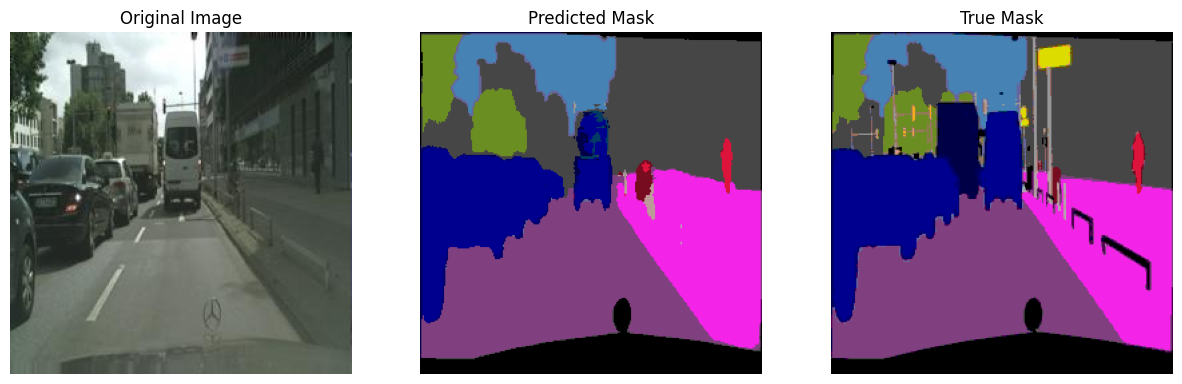

Validation: 100%|██████████| 149/149 [00:47<00:00,  3.17it/s]



Epoch [15/50]
Training Loss: 0.4706, Training mIoU: 0.3085
Validation Loss: 0.5394, Validation mIoU: 0.2972


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


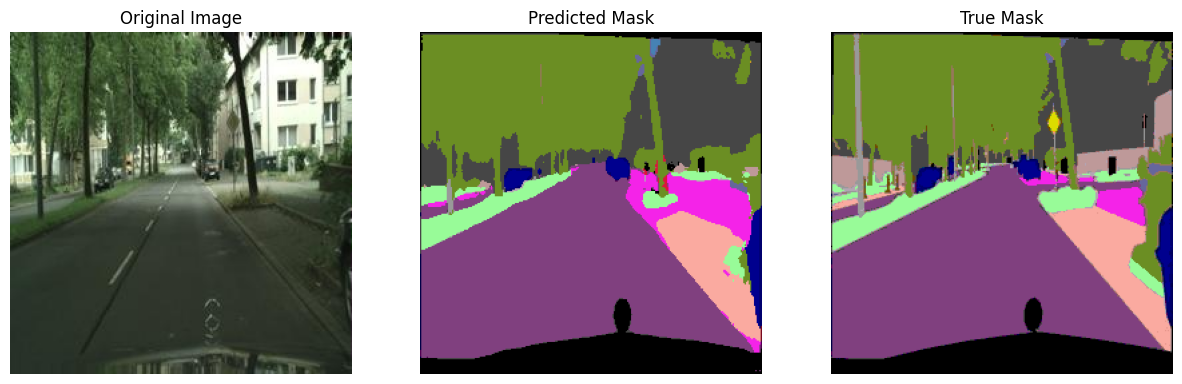

Validation: 100%|██████████| 149/149 [00:51<00:00,  2.88it/s]



Epoch [16/50]
Training Loss: 0.4594, Training mIoU: 0.3140
Validation Loss: 0.5226, Validation mIoU: 0.2976


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


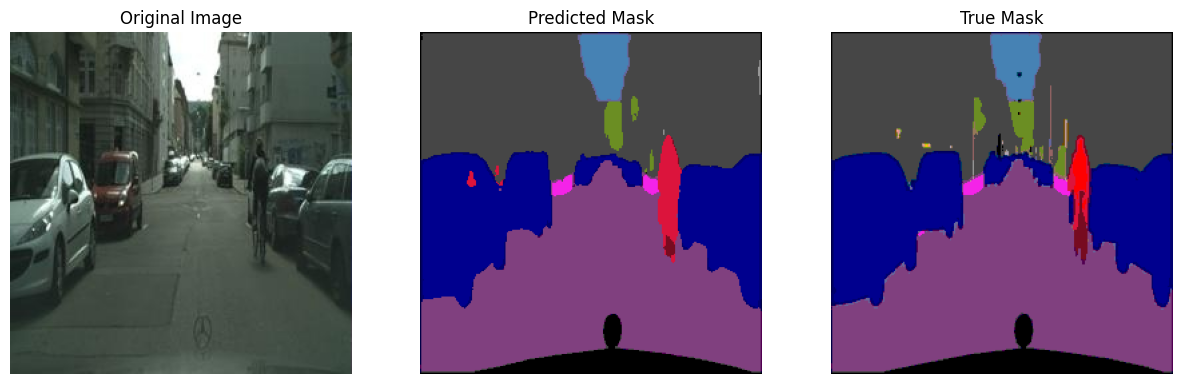

Validation: 100%|██████████| 149/149 [00:46<00:00,  3.23it/s]



Epoch [17/50]
Training Loss: 0.4459, Training mIoU: 0.3194
Validation Loss: 0.5167, Validation mIoU: 0.2992


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


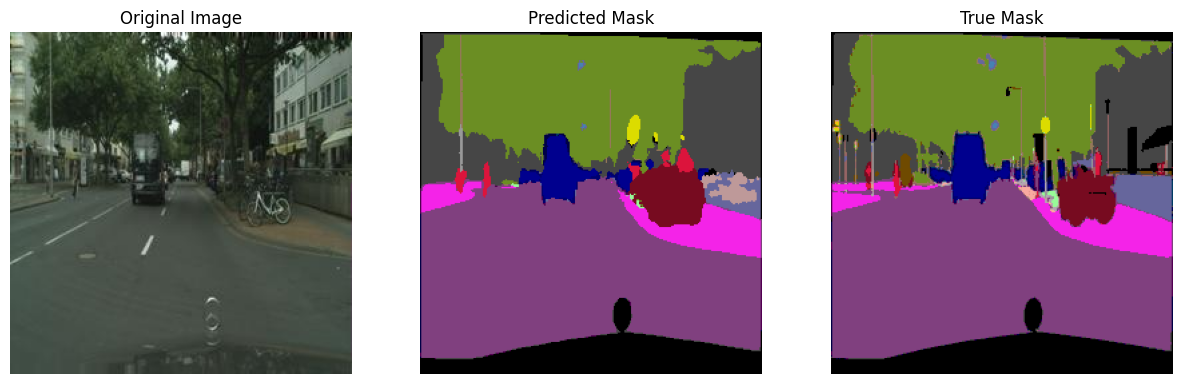

Validation: 100%|██████████| 149/149 [00:39<00:00,  3.78it/s]



Epoch [18/50]
Training Loss: 0.4383, Training mIoU: 0.3229
Validation Loss: 0.5057, Validation mIoU: 0.3056


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


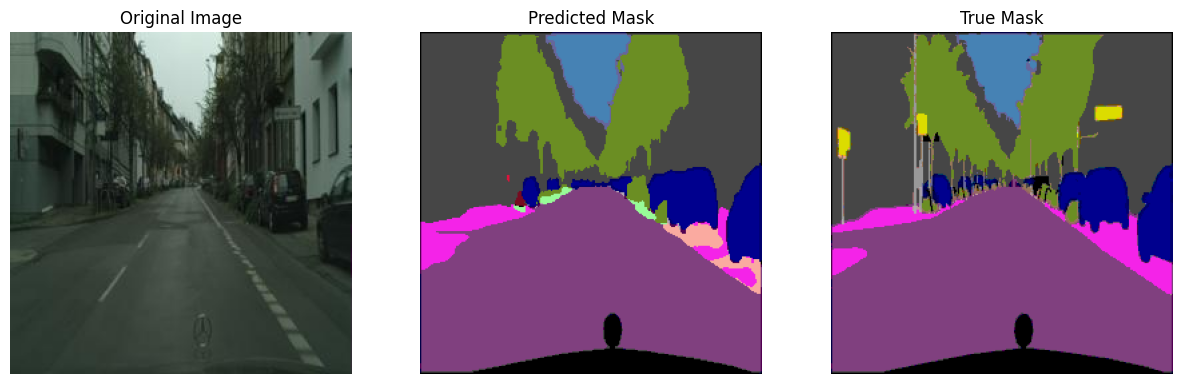

Validation: 100%|██████████| 149/149 [00:38<00:00,  3.89it/s]



Epoch [19/50]
Training Loss: 0.4244, Training mIoU: 0.3292
Validation Loss: 0.5196, Validation mIoU: 0.3046
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


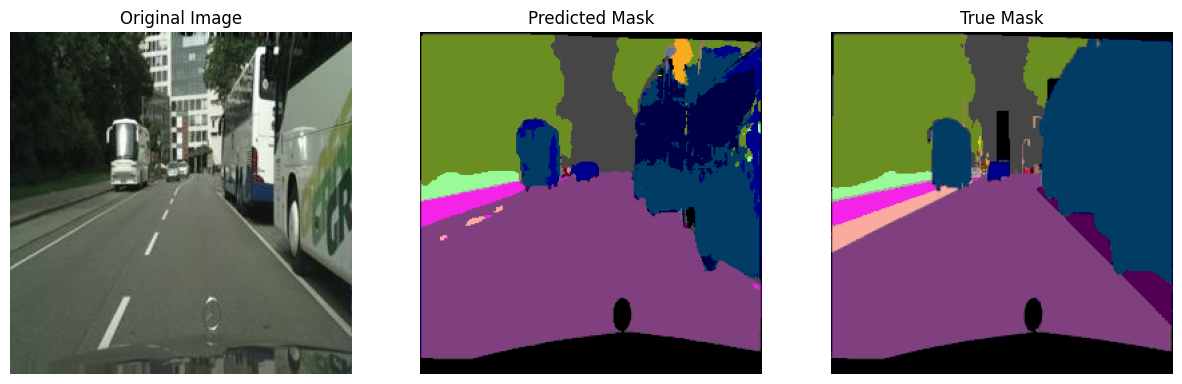

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.44it/s]



Epoch [20/50]
Training Loss: 0.4134, Training mIoU: 0.3343
Validation Loss: 0.5310, Validation mIoU: 0.3021
EarlyStopping counter: 2 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


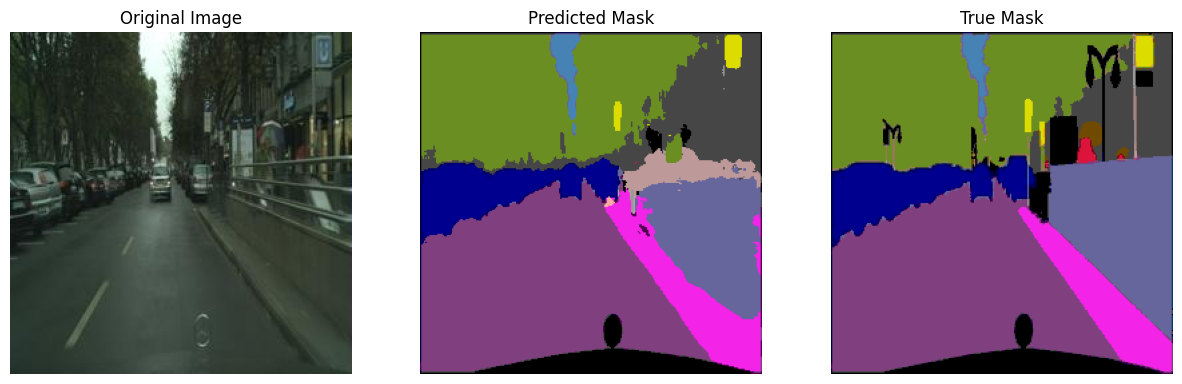

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.48it/s]



Epoch [21/50]
Training Loss: 0.4071, Training mIoU: 0.3366
Validation Loss: 0.4948, Validation mIoU: 0.3133


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


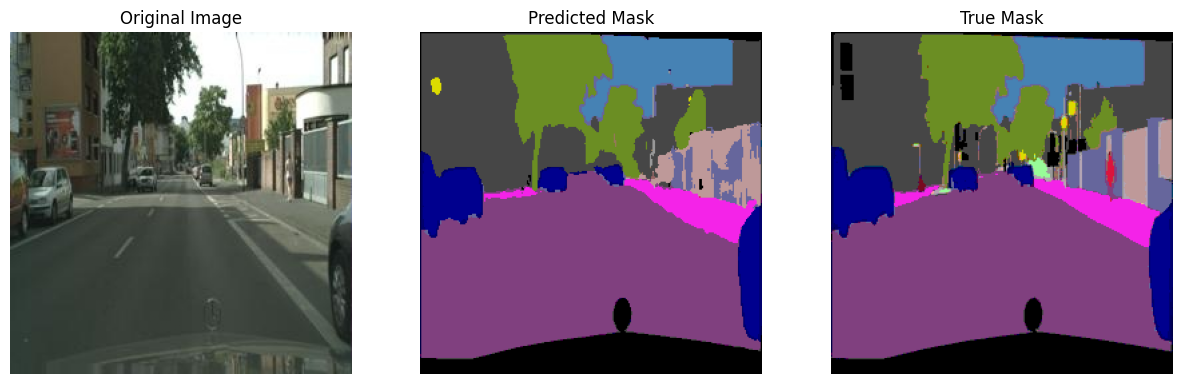

Validation: 100%|██████████| 149/149 [00:55<00:00,  2.67it/s]



Epoch [22/50]
Training Loss: 0.3973, Training mIoU: 0.3416
Validation Loss: 0.5324, Validation mIoU: 0.3081
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25
 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


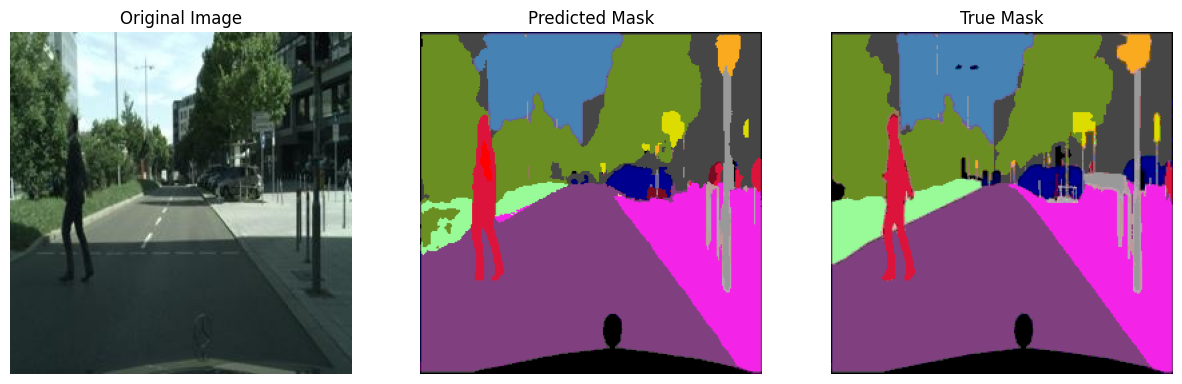

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.44it/s]



Epoch [23/50]
Training Loss: 0.3835, Training mIoU: 0.3485
Validation Loss: 0.5483, Validation mIoU: 0.3068
EarlyStopping counter: 2 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


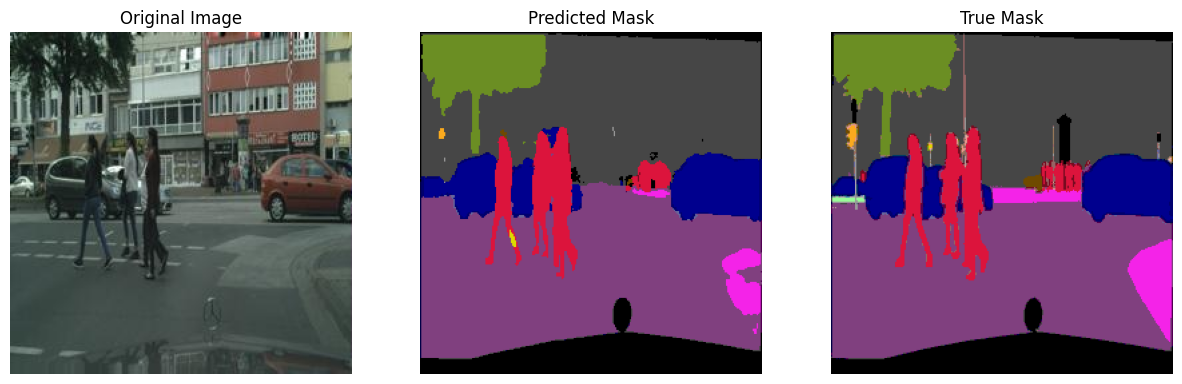

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.48it/s]



Epoch [24/50]
Training Loss: 0.3848, Training mIoU: 0.3495
Validation Loss: 0.5574, Validation mIoU: 0.3009
EarlyStopping counter: 3 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


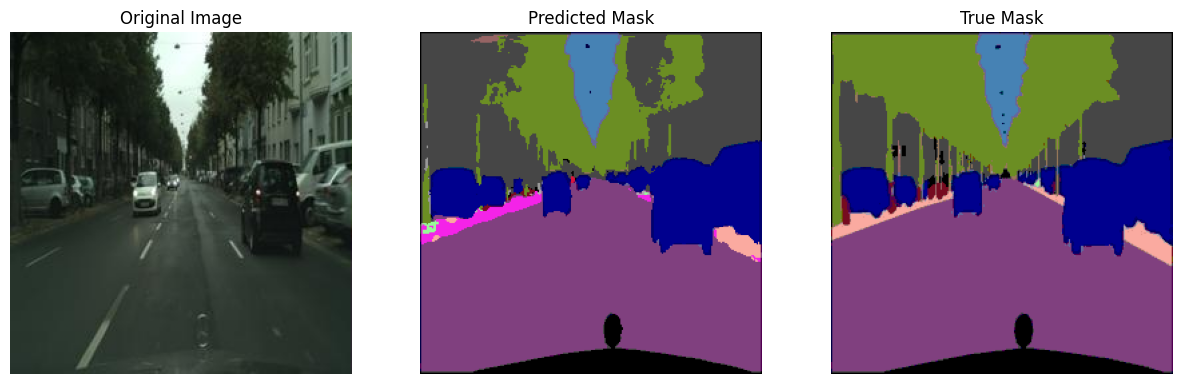

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.42it/s]



Epoch [25/50]
Training Loss: 0.3720, Training mIoU: 0.3551
Validation Loss: 0.5116, Validation mIoU: 0.3079
EarlyStopping counter: 4 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 15 16 17 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


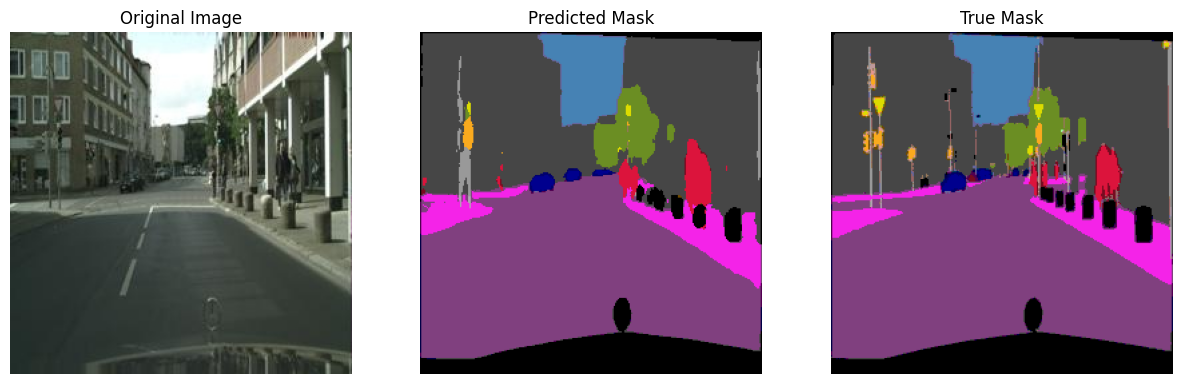

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.43it/s]



Epoch [26/50]
Training Loss: 0.3624, Training mIoU: 0.3616
Validation Loss: 0.4968, Validation mIoU: 0.3129
EarlyStopping counter: 5 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25
 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


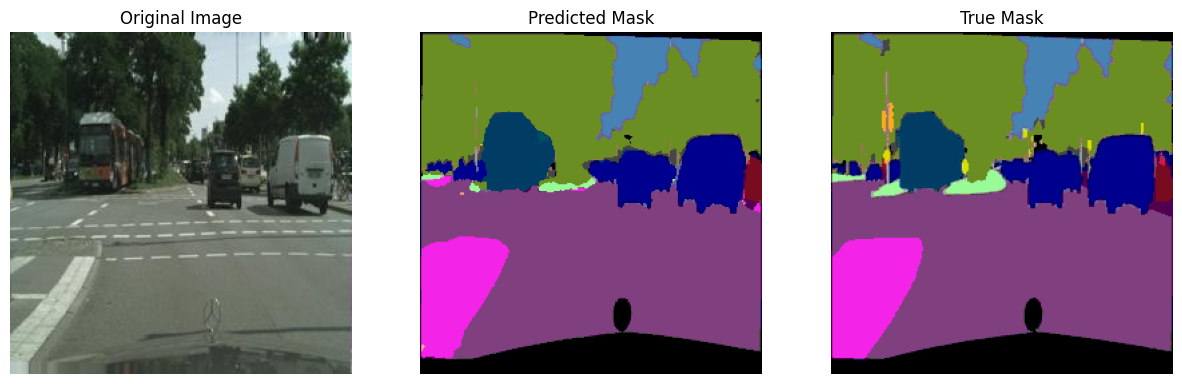

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.43it/s]



Epoch [27/50]
Training Loss: 0.3510, Training mIoU: 0.3659
Validation Loss: 0.5009, Validation mIoU: 0.3138
EarlyStopping counter: 6 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26
 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


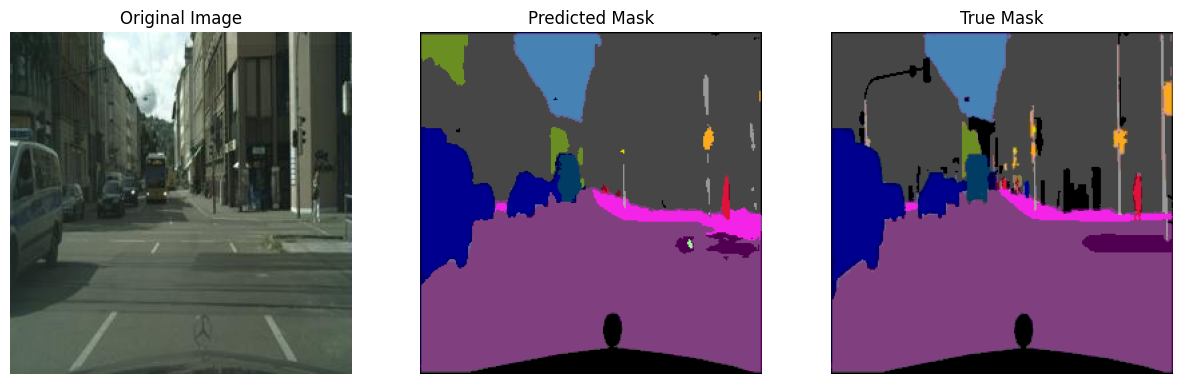

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.47it/s]



Epoch [28/50]
Training Loss: 0.3492, Training mIoU: 0.3684
Validation Loss: 0.5135, Validation mIoU: 0.3119
EarlyStopping counter: 7 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


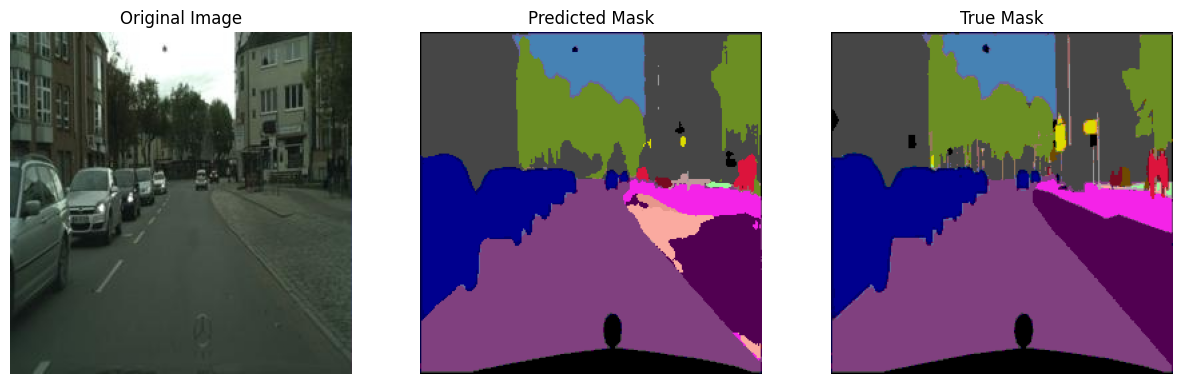

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.45it/s]



Epoch [29/50]
Training Loss: 0.3342, Training mIoU: 0.3766
Validation Loss: 0.5264, Validation mIoU: 0.3129
EarlyStopping counter: 8 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


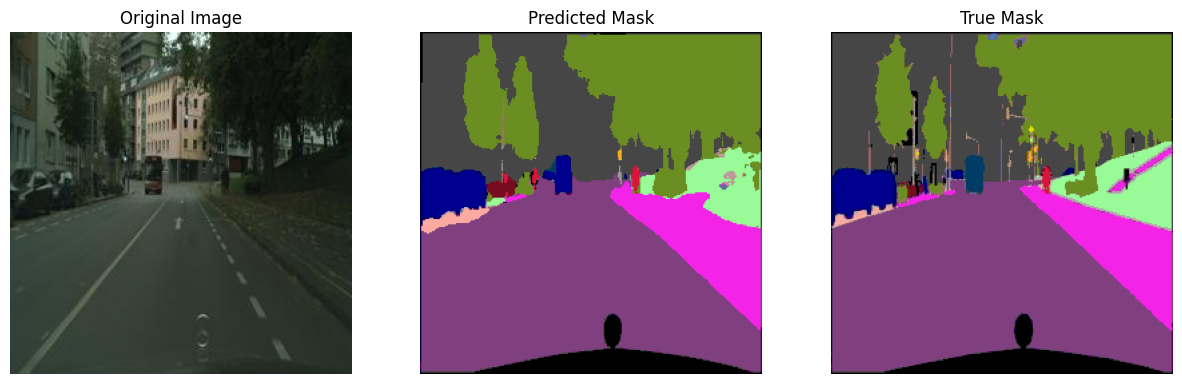

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.46it/s]



Epoch [30/50]
Training Loss: 0.3488, Training mIoU: 0.3712
Validation Loss: 0.4957, Validation mIoU: 0.3223
EarlyStopping counter: 9 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


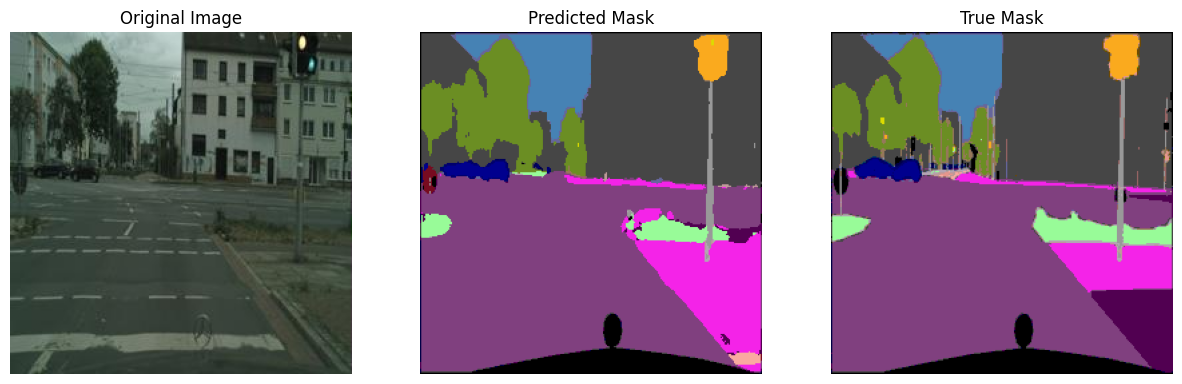

Validation: 100%|██████████| 149/149 [00:33<00:00,  4.46it/s]



Epoch [31/50]
Training Loss: 0.3226, Training mIoU: 0.3842
Validation Loss: 0.5051, Validation mIoU: 0.3181
EarlyStopping counter: 10 out of 10
Early stopping triggered
Training finished!


In [14]:
# Initialize model, loss function, and optimizer
model = get_seg_model(config).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=10, min_delta=0.001, verbose=True, min_epochs=10)

# Add these lists before the training loop to store metrics
train_losses = []
val_losses = []
train_mious = []
val_mious = []

# Initialize the IoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_batch_mious = []
    batch_idx = 0
    # Use tqdm for progress bar
    for (images, masks) in tqdm(train_loader):
        # Move data to device
        images = images.float().to(device)
        # Remove the channel dimension (squeeze) from masks
        masks = masks.squeeze(1).long().to(device)  # Changed from squeeze(3) to squeeze(1)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Print loss every 10 batches
        #if (batch_idx + 1) % 10 == 0:
        #    print(f'Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}')
        
        # Print predictions for the first batch of each epoch
        
         # Calculate training mIoU
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            batch_miou = jaccard(preds, masks)
            train_batch_mious.append(batch_miou.item())

        if batch_idx == 0:
            with torch.no_grad():
                # Get predictions
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Convert tensors to numpy for visualization
                pred_masks = pred_masks.cpu().numpy()
                true_masks = masks.cpu().numpy()
                
                # Print shapes and unique values for debugging
                print(f"\nPredicted mask shape: {pred_masks.shape}")
                print(f"True mask shape: {true_masks.shape}")
                print(f"Unique values in prediction: {np.unique(pred_masks)}")
                print(f"Unique values in true mask: {np.unique(true_masks)}")
                
                # Convert predictions and true masks to RGB using id_map
                pred_rgb = np.zeros((pred_masks.shape[0], pred_masks.shape[1], pred_masks.shape[2], 3))
                true_rgb = np.zeros((true_masks.shape[0], true_masks.shape[1], true_masks.shape[2], 3))
                
                for i in range(pred_masks.shape[0]):
                    for key, value in id_map.items():
                        pred_rgb[i][pred_masks[i] == key] = value
                        true_rgb[i][true_masks[i] == key] = value
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(images[0].cpu().permute(1,2,0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(pred_rgb[0].astype(np.uint8))
                plt.title('Predicted Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(true_rgb[0].astype(np.uint8))
                plt.title('True Mask')
                plt.axis('off')
                
                plt.show()
        batch_idx = batch_idx + 1
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_mious = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validation'):
            images = images.float().to(device)
            masks = masks.squeeze(1).long().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate validation mIoU
            preds = torch.argmax(outputs, dim=1)
            batch_miou = jaccard(preds, masks)
            val_batch_mious.append(batch_miou.item())


    # Print average loss for the epoch
    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    epoch_train_miou = np.mean(train_batch_mious)
    epoch_val_miou = np.mean(val_batch_mious)

    # Store metrics
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_mious.append(epoch_train_miou)
    val_mious.append(epoch_val_miou)

     # Print metrics
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training mIoU: {epoch_train_miou:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation mIoU: {epoch_val_miou:.4f}')

    # Early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        model.load_state_dict(early_stopping.best_model)
        break

print('Training finished!')

# Plotting

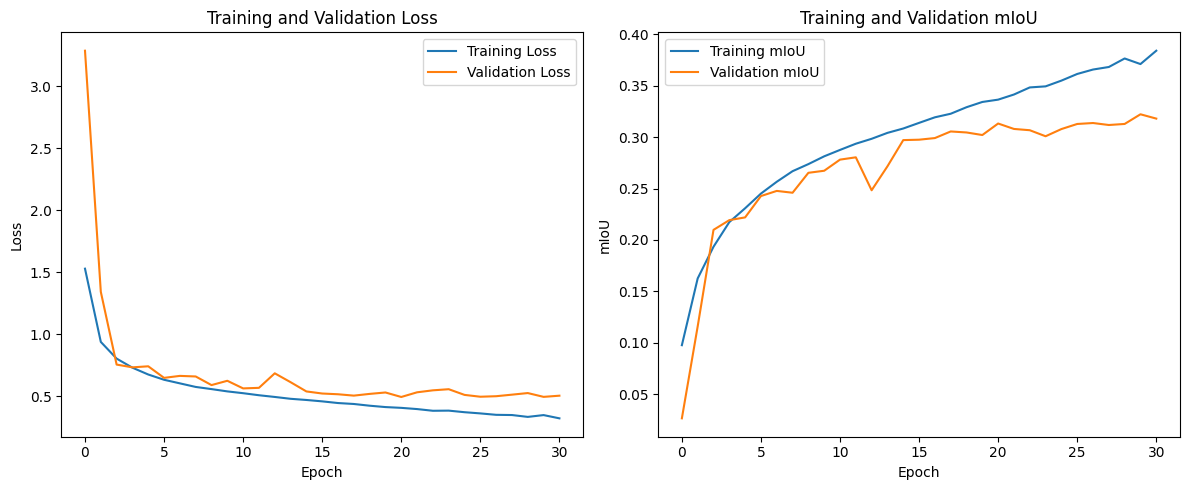

In [15]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# mIoU curve
plt.subplot(1, 2, 2)
plt.plot(train_mious, label='Training mIoU')
plt.plot(val_mious, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def save_model_as_npy(model, filepath):
    model_weights = model.state_dict()
    model_weights_dict = {k: v.cpu().numpy() for k, v in model_weights.items()}
    np.save(filepath, model_weights_dict)

In [17]:
save_model_as_npy(model, 'best_HRNet_weight.npy')

# Testing

Load weights successfully.


Testing:   0%|          | 0/125 [00:00<?, ?it/s]C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:437: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:438: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:439: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')



Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


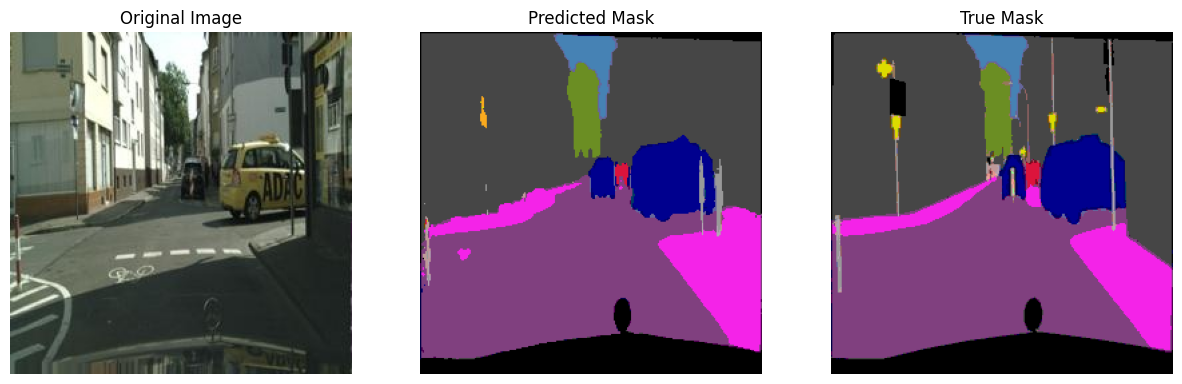

Testing: 100%|██████████| 125/125 [00:24<00:00,  5.20it/s]


Mean IoU: 0.2845
Mean Pixel Accuracy: 0.8422


Per-class IoU:   0%|          | 0/125 [00:00<?, ?it/s]


Mean IoU (excluding zeros): 0.3400
Mean IoU (including zeros): 0.2386
Mean Pixel Accuracy: 0.8422

IoU per class:
Class 0: 0.8306
Class 1: 0.0019
Class 2: 0.0657
Class 3: 0.7873
Class 4: 0.5100
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.6466
Class 8: 0.1512
Class 9: 0.2765
Class 10: 0.1396
Class 11: 0.0000
Class 12: 0.0464
Class 13: 0.0780
Class 14: 0.0000
Class 15: 0.1001
Class 16: 0.0696
Class 17: 0.8101
Class 18: 0.0062
Class 19: 0.8468
Class 20: 0.4106
Class 21: 0.0000
Class 22: 0.5006
Class 23: 0.3543
Class 24: 0.1792
Class 25: 0.0187
Class 26: 0.1860
Class 27: 0.0097
Class 28: 0.0000
Class 29: 0.1315

Number of classes with non-zero IoU: 21
Number of classes with zero IoU: 9


In [33]:
# Evaluate model (dummy example, replace with actual evaluation loop)
model = get_seg_model(config).to(device)
weights = np.load('best_HRNet_weight.npy', allow_pickle=True).item()

# Convert numpy arrays to torch tensors
state_dict = {k: torch.from_numpy(v) for k, v in weights.items()}
model.load_state_dict(state_dict)
print("Load weights successfully.")
model.eval()

image_dir = "../cityscapes_data/cityscapes_data/val"
mask_dir = "../cityscapes_data/cityscapes_data/val_mask"

dataset = CityscapeDataset(
        image_dir=image_dir,
        mask_dir=mask_dir
    )
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False
)

# Initialize the metric
jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

# Testing loop
model.eval()
miou_scores = []
pixel_accuracies = []


batch_idx = 0
with torch.no_grad():
    for images, masks in tqdm(dataloader, desc='Testing'):
        # Move data to device
        images = images.float().to(device)
        masks = masks.squeeze(1).long().to(device)  # Remove channel dimension
        
        # Forward pass
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate IoU
        batch_iou = jaccard(preds, masks)
        miou_scores.append(batch_iou.item())

         # Calculate pixel-wise accuracy
        correct_pixels = (preds == masks).sum().item()
        total_pixels = masks.numel()
        pixel_accuracy = correct_pixels / total_pixels
        pixel_accuracies.append(pixel_accuracy)

        # Print predictions for the first batch of each epoch
        if batch_idx == 0:
            with torch.no_grad():
                # Get predictions
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Convert tensors to numpy for visualization
                pred_masks = pred_masks.cpu().numpy()
                true_masks = masks.cpu().numpy()
                
                # Print shapes and unique values for debugging
                print(f"\nPredicted mask shape: {pred_masks.shape}")
                print(f"True mask shape: {true_masks.shape}")
                print(f"Unique values in prediction: {np.unique(pred_masks)}")
                print(f"Unique values in true mask: {np.unique(true_masks)}")
                
                # Convert predictions and true masks to RGB using id_map
                pred_rgb = np.zeros((pred_masks.shape[0], pred_masks.shape[1], pred_masks.shape[2], 3))
                true_rgb = np.zeros((true_masks.shape[0], true_masks.shape[1], true_masks.shape[2], 3))
                
                for i in range(pred_masks.shape[0]):
                    for key, value in id_map.items():
                        pred_rgb[i][pred_masks[i] == key] = value
                        true_rgb[i][true_masks[i] == key] = value
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(images[0].cpu().permute(1,2,0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(pred_rgb[0].astype(np.uint8))
                plt.title('Predicted Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(true_rgb[0].astype(np.uint8))
                plt.title('True Mask')
                plt.axis('off')
                
                plt.show()
        batch_idx = batch_idx + 1

# Calculate and print mean IoU and pixel-wise accuracy
mean_iou = np.mean(miou_scores)
mean_pixel_accuracy = np.mean(pixel_accuracies)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

# Calculate per-class IoU
class_iou = JaccardIndex(task="multiclass", num_classes=num_classes, average=None).to(device)
with torch.no_grad():
    for images, masks in tqdm(dataloader, desc='Per-class IoU'):
        images = images.float().to(device)
        masks = masks.squeeze(1).long().to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        iou_per_class = class_iou(preds, masks)
        break  # Just for one batch as example

# Move tensor to CPU and convert to numpy for calculations
iou_per_class = iou_per_class.cpu().numpy()

# Calculate mean IoU excluding zeros
non_zero_ious = [iou for iou in iou_per_class if iou > 0.01]
mean_iou_no_zeros = np.mean(non_zero_ious) if non_zero_ious else 0
mean_pixel_accuracy = np.mean(pixel_accuracies)

print(f"\nMean IoU (excluding zeros): {mean_iou_no_zeros:.4f}")
print(f"Mean IoU (including zeros): {np.mean(iou_per_class):.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

print("\nIoU per class:")
for class_id, iou in enumerate(iou_per_class):
    print(f"Class {class_id}: {iou:.4f}")

print(f"\nNumber of classes with non-zero IoU: {len(non_zero_ious)}")
print(f"Number of classes with zero IoU: {len(iou_per_class) - len(non_zero_ious)}")

# FLOPs

In [ ]:
from calflops import calculate_flops

# Define a dummy input tensor with the same shape as your input images
dummy_input = (1, 3, 256, 256)  # Adjust the size if your input size is different

# Initialize your model
model = get_seg_model(config).to(device)

flops, macs, params = calculate_flops(model=model, 
                                      input_shape=dummy_input,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  9.64 M  
fwd MACs:                                                               220.666 GMACs
fwd FLOPs:                                                              444.027 GFLOPS
fwd+bwd MACs:                                                           661.999 GMACs
fwd+bwd FLOPs:                                                          1.3321 TFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod

In [ ]:
# Import required libraries
from torchviz import make_dot
from torch.autograd import Variable

def visualize_model_architecture(model):
    # Create sample input matching RefineNet's expected input shape (B, C, H, W)
    x = Variable(torch.randn(1, 3, 256, 256)).to(device)
    
    # Get model output
    y = model(x)
    
    # Create dot graph
    dot = make_dot(y, params=dict(model.named_parameters()))
    
    # Customize graph appearance
    dot.attr(rankdir='TB')  # Top to bottom layout
    dot.attr('node', shape='box')
    
    # Save visualization
    dot.render('HRnet_architecture', format='png', cleanup=True)
    
    print("Model architecture visualization has been saved as 'refinenet_architecture.png'")

# Visualize model
model = get_seg_model(config).to(device)
visualize_model_architecture(model)

C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:437: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:438: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
C:\Users\113064516\AppData\Local\Temp\ipykernel_13260\3958124642.py:439: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.377235 to fit


Simplified model architecture visualization has been saved as 'hrnet_architecture_simplified.png'


In [35]:
def count_parameters(model):
    """
    Count the total number of trainable parameters in the model
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Convert to millions for better readability
    total_params_m = total_params / 1e6
    
    print(f'\nTotal Trainable Parameters: {total_params:,}')
    print(f'Total Trainable Parameters (M): {total_params_m:.2f}M')
    
    # Optional: Print parameters by layer
    print('\nParameters by layer:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel():,}')

# Call the function
model = get_seg_model(config).to(device)
count_parameters(model)


Total Trainable Parameters: 9,644,100
Total Trainable Parameters (M): 9.64M

Parameters by layer:
conv1.weight: 1,728
bn1.weight: 64
bn1.bias: 64
conv2.weight: 36,864
bn2.weight: 64
bn2.bias: 64
layer1.0.conv1.weight: 4,096
layer1.0.bn1.weight: 64
layer1.0.bn1.bias: 64
layer1.0.conv2.weight: 36,864
layer1.0.bn2.weight: 64
layer1.0.bn2.bias: 64
layer1.0.conv3.weight: 16,384
layer1.0.bn3.weight: 256
layer1.0.bn3.bias: 256
layer1.0.downsample.0.weight: 16,384
layer1.0.downsample.1.weight: 256
layer1.0.downsample.1.bias: 256
layer1.1.conv1.weight: 16,384
layer1.1.bn1.weight: 64
layer1.1.bn1.bias: 64
layer1.1.conv2.weight: 36,864
layer1.1.bn2.weight: 64
layer1.1.bn2.bias: 64
layer1.1.conv3.weight: 16,384
layer1.1.bn3.weight: 256
layer1.1.bn3.bias: 256
layer1.2.conv1.weight: 16,384
layer1.2.bn1.weight: 64
layer1.2.bn1.bias: 64
layer1.2.conv2.weight: 36,864
layer1.2.bn2.weight: 64
layer1.2.bn2.bias: 64
layer1.2.conv3.weight: 16,384
layer1.2.bn3.weight: 256
layer1.2.bn3.bias: 256
layer1.3.con